In [35]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import Lasso
import statsmodels.api as sm
np.random.seed(0)


In [ ]:

n_samples = 500
n_features = 10       
iter = 1000  
lam = 0.1    
                      

snfc_features = 3  
snfc = 5    
std_noise = 2     

X = np.random.normal(0, 1, size=(n_samples, n_features))


def create_data(X, p_features, snfc_features, snfc, std_noise):
    n = X.shape[0]

    true_beta = np.zeros(p_features)
    if snfc_features > p_features:
        snfc_features = p_features

    signal_indices = np.arange(snfc_features)
    for i, idx in enumerate(signal_indices):
        true_beta[idx] = snfc * ((-1)**i) 

    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size=n)
    y = linear_component + noise
    return y, true_beta


def fit_lasso_model_sklearn(X, y, lam):
    model = Lasso(alpha=lam, fit_intercept=True, tol=1e-4, max_iter=2000)
    model.fit(X, y)
    return model.coef_, model.intercept_

def fit_lasso_model(X, y, lam, max_iter = 7000, tol = 1e-5):
    def soft_thresolding(rho, lam, z):
        if rho < -lam:
            return (rho + lam)/z
        elif rho > lam:
            return (rho - lam)/z
        else:
            return 0
    n, p = X.shape
    beta = np.random.uniform(size = p)
    residual = y - X @ beta
    for iter in range(max_iter):
        beta_old = beta.copy()
        for j in range(p):
            r_j = residual + X[:, j] * beta[j]
            rho = 1/n * X[:, j].T @ r_j
            z = 1/n * (X[:, j] ** 2).sum()

            beta[j] = soft_thresolding(rho, lam, z)
            residual = r_j - X[:, j] * beta[j]
        if np.linalg.norm(beta - beta_old, ord=1) < tol:
            break
    intercept = np.mean(y) - np.sum(np.mean(X, axis = 0) * beta) 
    return beta, intercept
beta_hat_list = [] 
beta_true = None 
p_values_lists = []
def calculating_p_values(X, y, beta_hat, intercept_hat):
    pass
for i in range(iter):
    current_y, current_beta_true = create_data(X, n_features, snfc_features, snfc, std_noise)
    
    if i == 0: 
        beta_true = current_beta_true

    beta_hat, intercept_hat = fit_lasso_model(X, current_y, lam)
    
    beta_hat_list.append(np.concatenate([[intercept_hat], beta_hat]))


beta_hat_df = pd.DataFrame(beta_hat_list, columns = ['Intercept'] + [f'BetaX{i}' for i in range(n_features)])
columns = beta_hat_df.columns
beta_true = np.concatenate([[0], beta_true])

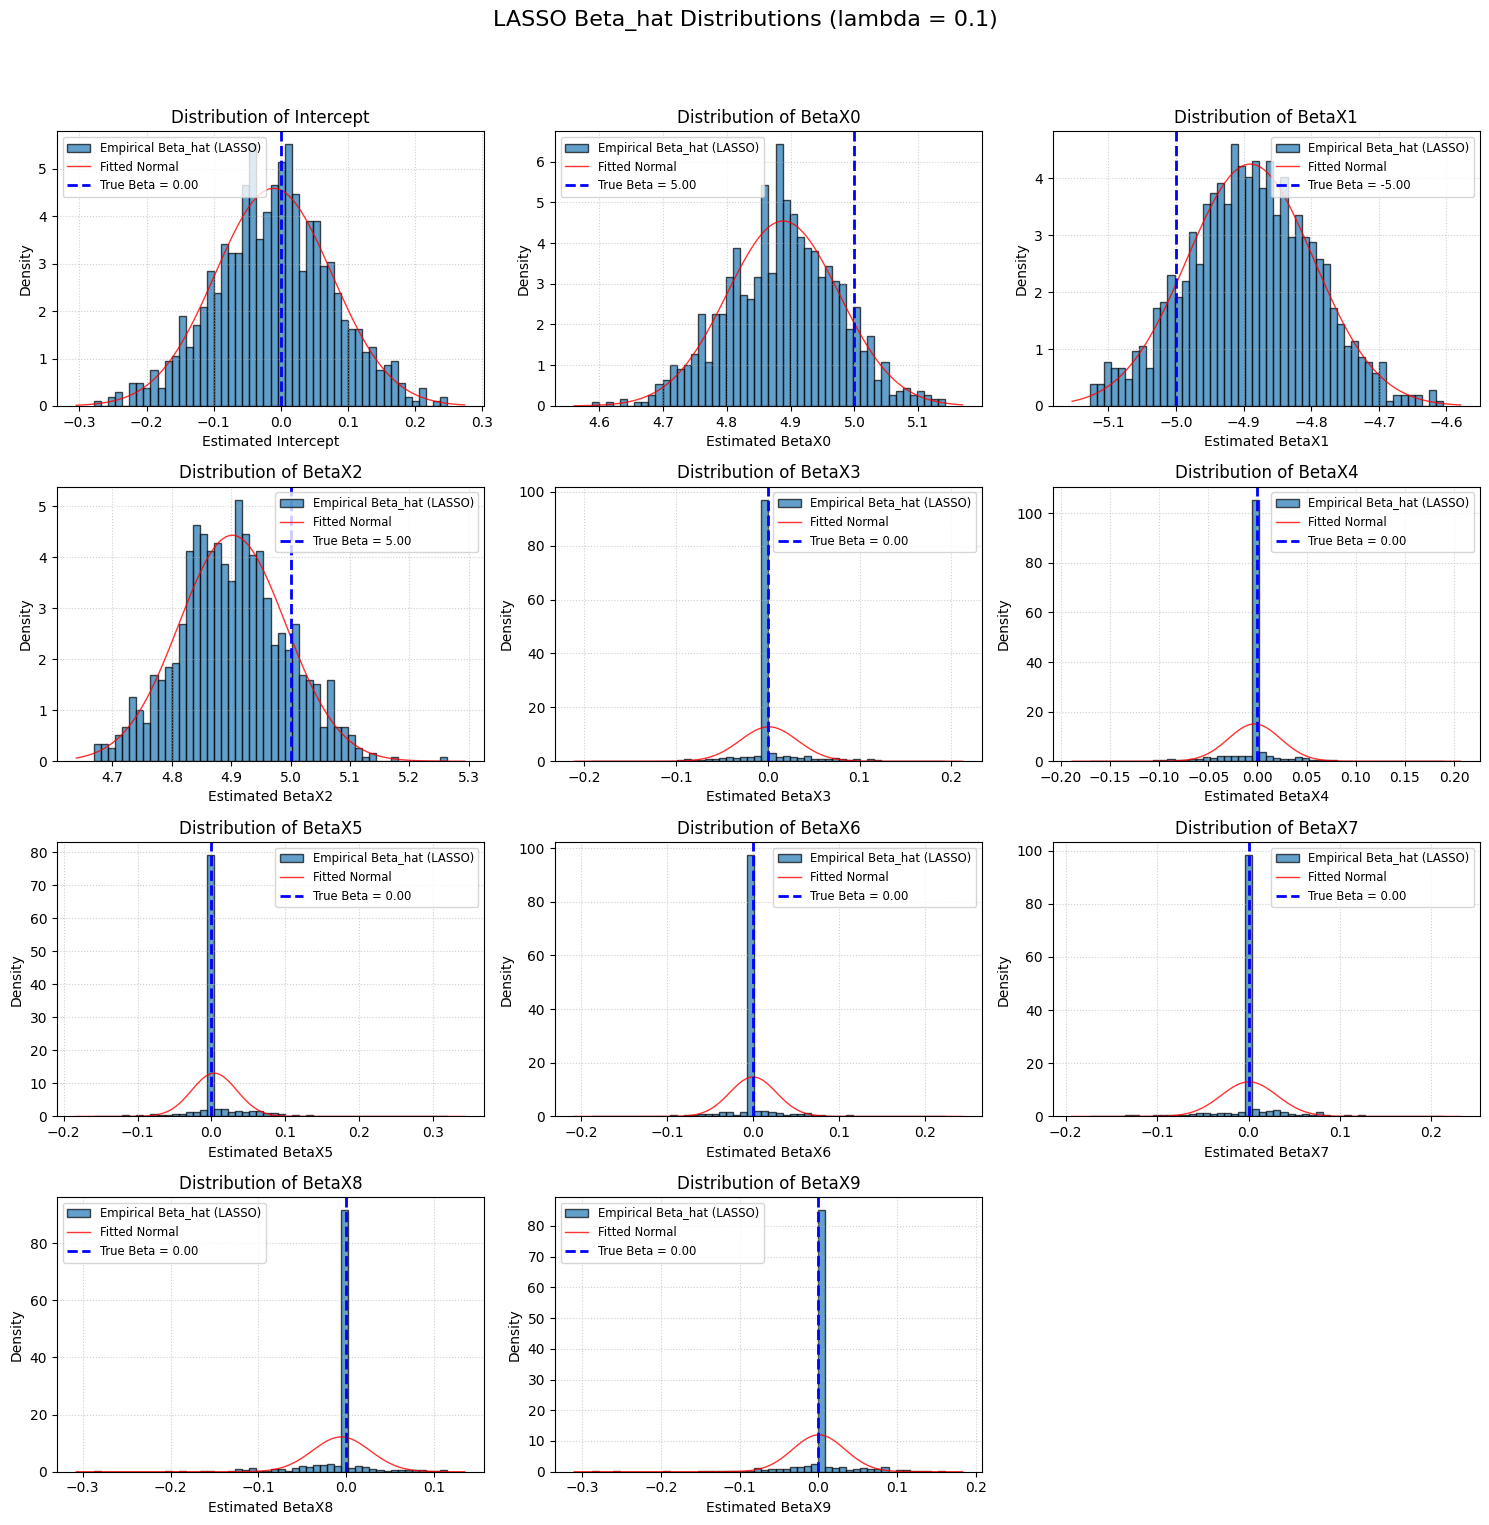

In [37]:

n_cols_plot = 3
n_rows_plot = int(np.ceil((n_features + 1) / n_cols_plot)) 
fig_b, axes_b = plt.subplots(n_rows_plot, n_cols_plot, figsize=(5 * n_cols_plot, 4 * n_rows_plot))
axes_b = axes_b.flatten()


for idx, col_name in enumerate(columns):
    if idx < len(axes_b):
        beta_values_for_hist = beta_hat_df[col_name]
        axes_b[idx].hist(beta_values_for_hist, bins=50, density=True, edgecolor='black', alpha=0.7, label='Empirical Beta_hat (LASSO)')
        
        mu_emp, std_emp = norm.fit(beta_values_for_hist)
        xmin_hist, xmax_hist = axes_b[idx].get_xlim()
        x_norm_emp = np.linspace(xmin_hist, xmax_hist, 100)
        p_norm_emp = norm.pdf(x_norm_emp, mu_emp, std_emp)
        axes_b[idx].plot(x_norm_emp, p_norm_emp, 'r-', linewidth=1, alpha=0.8, label=f'Fitted Normal')

        true_val_plot = beta_true[idx]
        axes_b[idx].axvline(true_val_plot, color='blue', linestyle='--', linewidth=2, label=f'True Beta = {true_val_plot:.2f}')
        
        axes_b[idx].set_title(f'Distribution of {col_name}')
        axes_b[idx].set_xlabel(f'Estimated {col_name}')
        axes_b[idx].set_ylabel('Density')
        axes_b[idx].legend(fontsize='small')
        axes_b[idx].grid(True, linestyle=':', alpha=0.6)

# Ẩn các subplot không sử dụng
for i in range(len(columns), len(axes_b)):
    fig_b.delaxes(axes_b[i])

fig_b.suptitle(f"LASSO Beta_hat Distributions (lambda = {lam})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()